In [1]:
from fastai.imports import *
from fastai.vision import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.functional as F

import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

In [2]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"

In [3]:
def get_img_id(fname):
    fname = fname.replace('_RGB.tif', '')
    img_id = "_".join(fname.split('_')[:-1])
    return img_id

train_img_ids = [get_img_id(f.name) for f in cropped_dir.ls() if f.name.endswith('RGB.tif')]
val_img_ids = [get_img_id(f.name) for f in cropped_val_dir.ls() if f.name.endswith('RGB.tif')]

In [4]:
labels_train_dir = data_dir / "cropped_training_labels"
labels_train_dir.mkdir(exist_ok=True)

labels_val_dir = data_dir / "cropped_validation_labels"
labels_val_dir.mkdir(exist_ok=True)

In [56]:
def parse_label(arr, label_val):
    item = np.argwhere(arr==label_val)
    y1, y2, x1, x2 = item[:,0].min(), item[:,0].max(), item[:,1].min(), item[:,1].max()
    x = int(0.5 * (x1+ x2))
    y = int(0.5 * (y1+y2) )
    w = x2 -x1
    h = y2-y1
    return x, y, w, h
def label_to_str(label_out_tuple):
    return " ".join(list(map(str, label_out_tuple)))

def parse_img(img_fname, dataset_type="training"):
    label_img = sktif.imread(str(data_dir / f"cropped_{dataset_type}"/ img_fname))
    label_filepath =data_dir / f"cropped_{dataset_type}_labels/{img_fname.replace('.tif', '.txt')}"
    max_label = label_img.max()
    
    min_label = np.min(label_img[np.nonzero(label_img)]) if max_label > 0 else 0
    valid_labels = [x for x in range(min_label, max_label + 1) if len(np.where(label_img == x)[0]) > 0]
    
    with open(label_filepath, 'w') as f:
        [f.write(f"{img_fname.replace('.tif','')} {label_to_str(parse_label(label_img, label_val))}\n") \
         for label_val in valid_labels]
    
    
    

In [57]:
cropped_train_fnames =[f.name for f in ( data_dir / "cropped_training").ls() if f.name.endswith('GTI.tif')]
cropped_val_fnames =[f.name for f in ( data_dir / "cropped_validation").ls() if f.name.endswith('GTI.tif')]

In [58]:
%time out=[parse_img(fname) for fname in cropped_train_fnames]

CPU times: user 17.5 s, sys: 208 ms, total: 17.7 s
Wall time: 26.9 s


In [59]:
%time out=[parse_img(fname,  dataset_type="validation") for fname in cropped_val_fnames]

CPU times: user 3.68 s, sys: 16.6 ms, total: 3.69 s
Wall time: 5.83 s


In [ ]:
def get_data(bs, size):
    src = (ObjectItemList.from_folder(cropped_dir)
           .split_by_files(cropped_val_dir)
          )
    

In [6]:
img2bbox = {}


In [ ]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   

In [9]:
train_images, train_lbl_bbox =get_annotations('/media/wwymak/Storage/fastai_dl2_2018/pascal_2012/train.json')

In [11]:
train_images[:5]

['2008_000008.jpg',
 '2008_000015.jpg',
 '2008_000019.jpg',
 '2008_000023.jpg',
 '2008_000028.jpg']

In [13]:
train_lbl_bbox[0]

[[[86, 52, 420, 471], [43, 157, 167, 289]], ['horse', 'person']]

In [14]:
img2bbox??

Object `img2bbox` not found.


In [15]:
cropped_train_fnames[:5]

['TAM_Tile_030_11_GTI.tif',
 'TAM_Tile_111_7_GTI.tif',
 'JAX_Tile_096_14_GTI.tif',
 'TAM_Tile_005_5_GTI.tif',
 'JAX_Tile_080_1_GTI.tif']

In [60]:
label_filepaths =[data_dir / "cropped_training_labels"/f"{img_fname.replace('.tif', '.txt')}" for img_fname in cropped_train_fnames]

In [61]:
validation_label_filepaths =[data_dir / f"cropped_validation_labels/{img_fname.replace('.tif', '.txt')}" for img_fname in cropped_val_fnames]

In [67]:
def parse_label_file(fpath):
    df = pd.read_csv(fpath, header=None, sep=" ", names=['id', 'x', 'y', 'w', 'h'])
    df['output'] = df.apply(lambda row: [row.y-row.h/2, row.x-row.w/2, row.h/2 + row.y, row.x + row.w/2], axis=1)
    return [list(df["output"]), ['building'] * len(df['output'])]

In [68]:
train_labels_bbox = [parse_label_file(f) for f in label_filepaths]
train_labels_bbox[0]

[[[0.0, 210.0, 20.0, 232.0],
  [-0.5, 239.5, 20.5, 254.5],
  [8.0, 186.0, 24.0, 202.0],
  [22.5, 108.0, 43.5, 132.0],
  [36.5, 0.0, 47.5, 26.0],
  [49.5, 104.5, 72.5, 129.5],
  [67.0, 239.5, 103.0, 254.5],
  [70.5, 216.0, 101.5, 230.0],
  [135.0, 13.0, 155.0, 35.0],
  [149.0, 233.0, 177.0, 255.0],
  [229.5, 43.0, 254.5, 61.0],
  [231.5, 207.5, 254.5, 222.5],
  [233.0, 80.0, 255.0, 126.0],
  [233.5, 12.5, 254.5, 29.5],
  [233.5, 179.0, 252.5, 199.0],
  [235.0, 235.0, 255.0, 255.0],
  [237.0, 0.0, 255.0, 4.0]],
 ['building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building',
  'building']]

In [69]:
val_labels_bbox = [parse_label_file(f) for f in validation_label_filepaths]


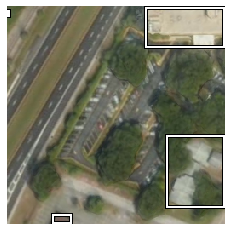

In [70]:
img = open_image(data_dir / "cropped_training"/ cropped_train_fnames[1].replace('GTI', 'RGB'))
bbox = ImageBBox.create(*img.size, train_labels_bbox[1][0])
img.show(figsize=(6,4), y=bbox)

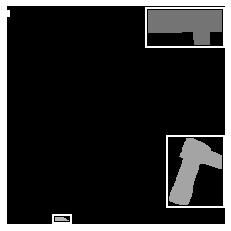

In [71]:
img = open_image(data_dir / "cropped_training"/ cropped_train_fnames[1])
img.show(figsize=(6,4), y=bbox)

In [89]:
train_img_names = [f.name.replace('GTI', 'RGB').replace('txt', 'tif') for f in label_filepaths]
valid_img_names = [f.name.replace('GTI', 'RGB').replace('txt', 'tif') for f in validation_label_filepaths]

img_names = train_img_names + valid_img_names
bboxes = train_labels_bbox + val_labels_bbox

assert len(img_names) == len(bboxes)

In [90]:
img2bbox = dict(zip(img_names, bboxes))
get_y_func = lambda o:img2bbox[o.name]

In [91]:
def get_data(size=128, bs=32):
    src = (ObjectItemList.from_folder(data_dir)
            .filter_by_func(lambda fname: Path(fname).name.endswith('RGB.tif'))
            .split_by_folder(train="cropped_training", valid="cropped_valid")
           .label_from_func(get_y_func)
           .transform(get_transforms(do_flip=True, 
                                     
                 flip_vert=True, 
                 max_rotate=180, 
                 max_zoom=1.2, 
                 max_lighting=0.5,
                 max_warp=0.2, 
                 p_affine=0.75, 
                 p_lighting=0.75), size=size,  tfm_y=True)
            .databunch(bs=bs, collate_fn = bb_pad_collate)
          )
    return src


In [92]:
data = get_data()

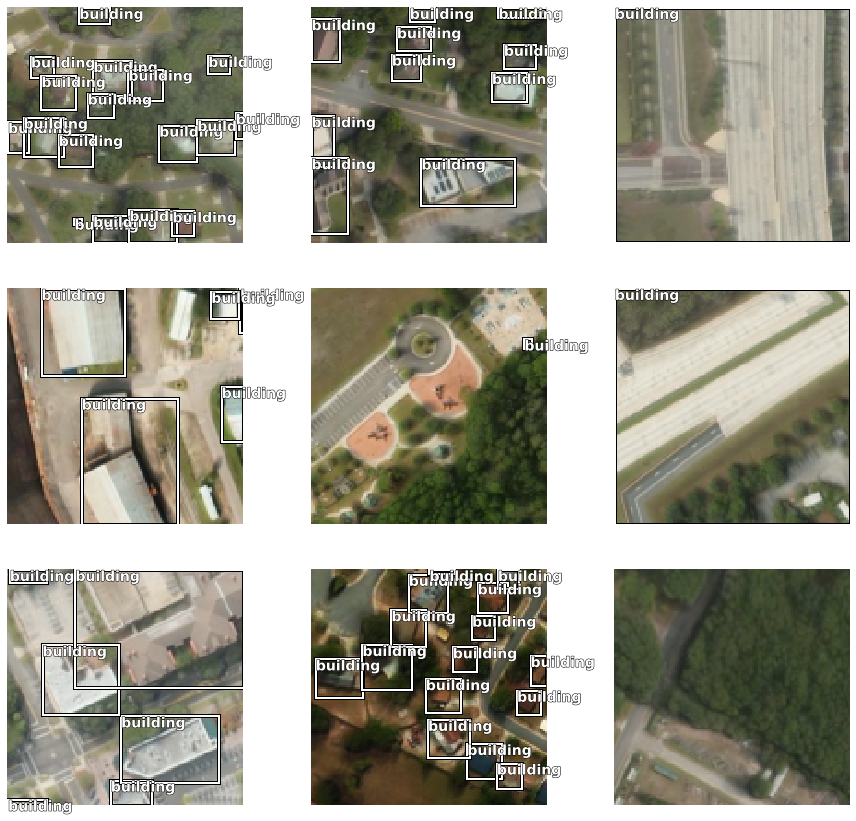

In [93]:
data.show_batch(rows=3)